# Weather Classification Project

## Overview
This project builds a machine learning classifier to predict weather conditions based on hourly meteorological data from weather stations across the U.S. The classifier categorizes weather into five classes: **Clear**, **Cloudy**, **Rain**, **Snow**, and **Storm (Not sampled due to low label rate)**.

## Data Pipeline
1. **Data Collection**: Retrieved 2024 hourly weather data from 20 weather stations using the [Meteostat API](https://dev.meteostat.net/)
2. **Feature Engineering**: 
   - Dropped Highly missing features (total sunshine, snow depth, precipitation, wind gust)
   - Created lagged features (lag 1, 2, 3) for all meteorological variables to capture temporal patterns
3. **Data Cleaning**: Removed rows with missing values before sampling
4. **Geographic Integration**: Merged latitude/longitude data to enable spatial analysis

## Target Variable
**Weather Condition (coco)** — Grouped into 5 categories:
- **Clear**
- **Cloudy**
- **Rain**
- **Snow**
- **Storm** 

## Model 
- **Algorithm**: Random Forest Classifier
- **Train-Test Split**: 80/20 with stratification

## Performance metrics 
- **Accuracy**:  0.7279
- **Precision**: 0.7258
- **Recall**:    0.7279
- **F1 Score**:  0.7156


In [47]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from meteostat import Point, Stations, Hourly, Daily

from great_tables import GT, md, style, loc
import altair as alt
from vega_datasets import data as datasets

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
stations = Stations()
stations = stations.nearby(40.4406, -79.9959)
stations = stations.fetch()

stations = stations[stations["country"]=="US"].sample(20,random_state=42)
#print(stations)
# --- map base ---
us_states = alt.topo_feature(datasets.us_10m.url, 'states')


base = (
    alt.Chart(us_states)
    .mark_geoshape(fill="#f0f0f0", stroke="black")
    .project("albersUsa")
)

# --- stations ---
points = (
    alt.Chart(stations.reset_index())
    .mark_circle(size=200, opacity=0.8)
    .encode(
        longitude="longitude:Q",
        latitude= "latitude:Q",
        color="name:N",
        tooltip=["name:N","id:N" , "longitude:Q", "latitude:Q"]
    )
)
(base + points ).properties(
    width=600,
    height=400,
    title="Sample Weather stations"
)


alt.LayerChart(...)

In [55]:

data = Hourly(stations, datetime.datetime(2024, 1, 1), datetime.datetime(2024, 12, 31))
data = data.fetch()
print(len(data))

data = data.drop(columns=["tsun", "snow", "prcp","wpgt"])


# 1) Ensure time level is datetime
data = data.copy()
data.index = data.index.set_levels(
    pd.to_datetime(data.index.levels[1]),
    level=1
)

# 2) Sort by station -> time
data = data.sort_index(level=["station", "time"])

# 3) Identify columns to lag
cols = list(data.columns)
cols.remove("coco")  

# 4) Make lag features (lag1, lag2, lag3)
for lag in [1, 2, 3]:
    lagged = data.groupby(level="station")[cols].shift(lag)
    lagged.columns = [f"{c}_lag{lag}" for c in cols]
    data = data.join(lagged)


data.loc["PFNO0"]
data = data.dropna()

# Reset data index to merge
data_reset = data.reset_index()

# Merge latitude and longitude from stations using index
data_reset = data_reset.merge(
    stations[['latitude', 'longitude']],
    left_on='station',
    right_index=True,
    how='left'
)

# Set MultiIndex back if desired
data_reset = data_reset.set_index(['station', 'time'])

# Replace original data
data = data_reset



print(len(data))
#print(data.isnull().sum(axis=0))


def group_condition_codes(code):
    
    if code in [1, 2]:
        return "Clear"
    elif code in [3, 4, 5, 6]:
        return "Cloudy"
    elif code in [7, 8, 9, 10, 11, 12, 13, 17, 18, 19, 20]:
        return "Rain"
    elif code in [14, 15, 16, 21, 22]:
        return "Snow"
    elif code in [23, 24, 25, 26, 27]:
        return "Storm"

data["coco"] = data['coco'].apply(group_condition_codes)
data["coco"].value_counts(normalize=True) * 100

156383
152964
152964


coco
Clear     53.015742
Cloudy    39.072592
Rain       7.153971
Snow       0.757695
Name: proportion, dtype: float64

In [49]:

# -----------------------------
# 1. Build X and y
# -----------------------------
target = "coco"  # your classification target

y = data[target]
X = data.drop(columns=[target])

# Drop MultiIndex
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Keep only numeric features
X = X.select_dtypes(include="number")

# Drop rows with NaN (from lag features)
X = X.dropna()
y = y.loc[X.index]  # align y

# -----------------------------
# 2. Train-test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)



In [50]:

# -----------------------------
# 3. Random Forest Classifier
# -----------------------------
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,       # None = expand until all leaves are pure
    random_state=42,
    n_jobs=-1             # use all CPU cores
)

# -----------------------------
# 4. Fit the model
# -----------------------------
rf.fit(X_train, y_train)

# -----------------------------
# 5. Predict + evaluate
# -----------------------------
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.7278789265518256

Classification Report:
               precision    recall  f1-score   support

       Clear       0.75      0.87      0.81     16219
      Cloudy       0.69      0.62      0.65     11953
        Rain       0.75      0.28      0.41      2189
        Snow       0.81      0.47      0.59       232

    accuracy                           0.73     30593
   macro avg       0.75      0.56      0.61     30593
weighted avg       0.73      0.73      0.72     30593



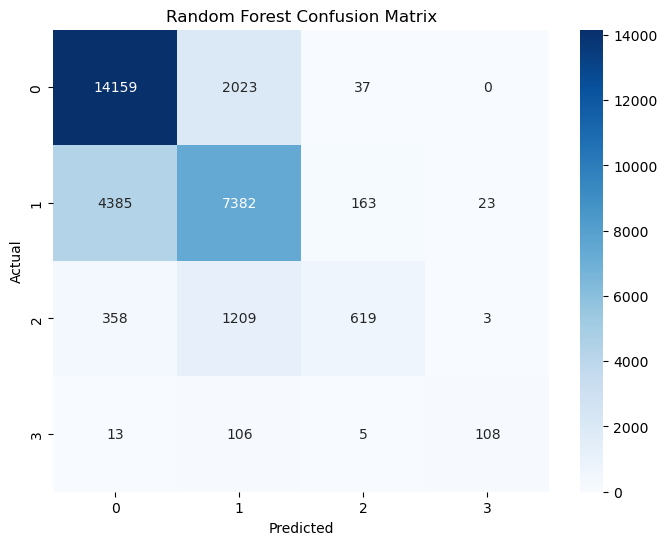

In [54]:
# -----------------------------
# Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()



rhum         0.054559
rhum_lag3    0.048343
rhum_lag2    0.044335
rhum_lag1    0.044129
pres         0.043709
dwpt         0.040278
wdir_lag3    0.039408
pres_lag3    0.039282
pres_lag1    0.038955
wdir         0.038643
dwpt_lag3    0.038585
wdir_lag2    0.037932
wdir_lag1    0.037725
pres_lag2    0.037607
dwpt_lag1    0.037445
temp_lag3    0.036913
dwpt_lag2    0.036806
temp         0.036726
wspd         0.034735
longitude    0.034514
wspd_lag1    0.033947
temp_lag1    0.033688
wspd_lag3    0.033673
wspd_lag2    0.033425
temp_lag2    0.033015
latitude     0.031623
dtype: float64


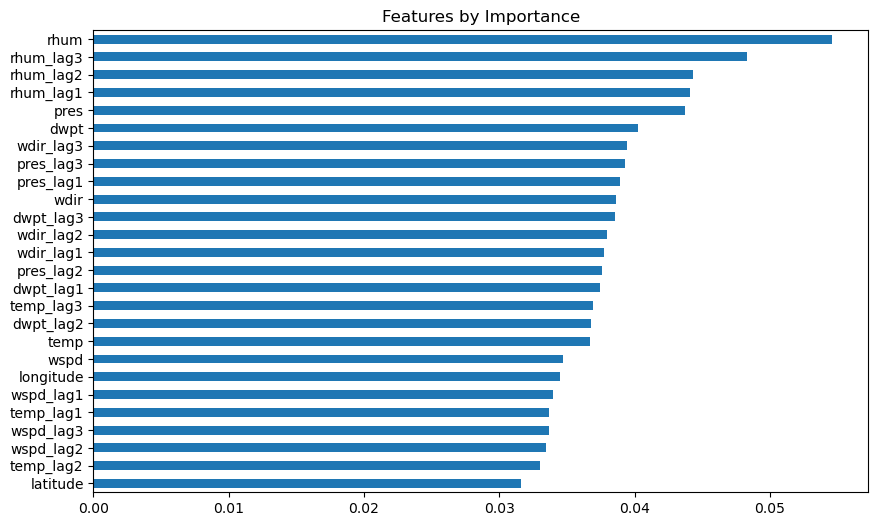

In [ ]:
# -----------------------------
# Feature importance
# -----------------------------
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)
#print(importances)  # top 20 features


importances.plot(kind='barh', figsize=(10,6))
plt.gca().invert_yaxis()
plt.title("Features by Importance")
plt.show()



In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Display results
print("=" * 50)
print("MODEL PERFORMANCE METRICS")
print("=" * 50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("=" * 50)

MODEL PERFORMANCE METRICS
Accuracy:  0.7279
Precision: 0.7258
Recall:    0.7279
F1 Score:  0.7156
